# get gcmt events and FDSN stations

In [19]:
import obspy
import spherical_geometry # pip install spherical_geometry
from spherical_geometry.polygon import SphericalPolygon
import numpy as np
%matplotlib inline

## Get gcmt events using obspy.ndk

In [7]:
# url for ndk files
def get_ndk_url(year,month):
    if(year<2006):
        raise Exception("no support before year 2006")
    elif((year>2019) or ((year==2019) and month>2)):
        raise Exception("no support after 2019-02")
    else:
        # f string support after python3.6
        month_mapper=["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"]
        year_2letter=year-2000
        url=f"https://www.ldeo.columbia.edu/~gcmt/projects/CMT/catalog/NEW_MONTHLY/{year}/{month_mapper[month-1]}{year_2letter:02d}.ndk"
        return url

In [9]:
# read all the events in ndk files (eg: from 2011-01-01 to 2018-06-31) After 2018-06-31, there may be problems

In [17]:
events_catalog=obspy.core.event.catalog.Catalog()
for year in range(2011,2019):
    print(f"year {year}")
    if(year!=2018):
        for month in range(1,13):
            events_catalog+=obspy.read_events(get_ndk_url(year,month))
    else:
        for month in range(1,7):
            events_catalog+=obspy.read_events(get_ndk_url(year,month))        

year 2011
year 2012
year 2013
year 2014
year 2015
year 2016
year 2017
year 2018


In [18]:
events_catalog

16831 Event(s) in Catalog:
2011-01-01T01:56:07.800000Z | +39.440,  +75.160 | 4.93 Mwc
2011-01-01T09:57:03.800000Z | -27.020,  -63.210 | 7.03 Mwc
...
2018-06-30T17:43:25.800000Z | +13.320,  +50.600 | 4.82 Mwc
2018-06-30T21:01:33.900000Z | -18.870, -174.220 | 4.92 Mwc
To see all events call 'print(CatalogObject.__str__(print_all=True))'

In [24]:
# select events in the box
# lon and lat are copied from specfem (the corner points, one of the .h file in setup)
lon = [91.3320117152011, 74.6060844556399,
       174.409435753150, 144.284491292185, 91.3320117152011]
lat = [9.37366242174489, 61.1396992149365,
       48.6744705245903, 2.08633373396527, 9.37366242174489]
# sp is a SphericalPolygon
coordinate = []
for i, j in zip(lon, lat):
    phi = np.deg2rad(i)
    theta = np.deg2rad(90-j)
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    coordinate.append((x, y, z))
sp = SphericalPolygon(coordinate)

In [25]:
# events_catalog_box is events inside in the box:
events_catalog_box=obspy.core.event.catalog.Catalog()
for item in events_catalog:
    origin=item.origins[0]
    lat=origin.latitude
    lon=origin.longitude
    # convert coordinate
    phi = np.deg2rad(lon)
    theta = np.deg2rad(90-lat)
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    
    if(sp.contains_point((x, y, z))):
        events_catalog_box+=item

In [26]:
events_catalog_box

3061 Event(s) in Catalog:
2011-01-05T00:57:33.700000Z | +31.490, +142.290 | 5.6 Mwc
2011-01-08T18:23:24.000000Z | +26.770, +143.900 | 5.07 Mwc
...
2018-06-26T08:00:12.600000Z | +35.080, +132.730 | 4.82 Mwc
2018-06-27T18:27:49.400000Z | +13.100, +145.910 | 4.94 Mwc
To see all events call 'print(CatalogObject.__str__(print_all=True))'

In [27]:
# if we want to get all the events with mag>5
events_catalog_box_mag_gt_5=events_catalog_box.filter("magnitude >= 5.0")

In [28]:
events_catalog_box_mag_gt_5

1993 Event(s) in Catalog:
2011-01-05T00:57:33.700000Z | +31.490, +142.290 | 5.6 Mwc
2011-01-08T18:23:24.000000Z | +26.770, +143.900 | 5.07 Mwc
...
2018-06-17T22:58:36.700000Z | +34.830, +135.470 | 5.59 Mwc
2018-06-18T05:22:40.000000Z | +20.180, +121.150 | 5.03 Mwc
To see all events call 'print(CatalogObject.__str__(print_all=True))'

/Users/ziyixi/anaconda3/envs/seismology/lib/python3.6/site-packages/obspy/imaging/maps.py:343: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  ax=ax)
/Users/ziyixi/anaconda3/envs/seismology/lib/python3.6/site-packages/obspy/imaging/maps.py:435: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  bmap.drawcountries(color="0.75")


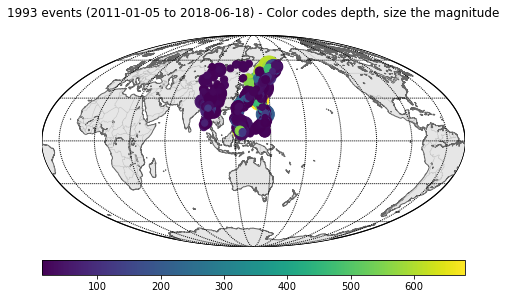

In [30]:
events_catalog_box_mag_gt_5.plot();

### In order to know the gcmt id:

In [38]:
events_catalog_box_mag_gt_5[0].origins[0].resource_id.id.split("/")[-2]

'C201101050057A'

### I don't remember what other restrictions I have applied as it seems there are more events than I have. In order to get the CMTSOUTION file:

In [39]:
events_catalog_box_mag_gt_5[0].write("C201101050057A.CMTSOLUTION",format="CMTSOLUTION")

/Users/ziyixi/anaconda3/envs/seismology/lib/python3.6/site-packages/obspy/io/cmtsolution/core.py:368: UserWarning: No body wave magnitude found. Will be replaced by the first magnitude in the event object.
  warnings.warn("No body wave magnitude found. Will be replaced by the "


In [45]:
with open("C201101050057A.CMTSOLUTION","r") as f:
    for line in f:
        print(line,end="")

 PDE 2011 01 05 00 57 32.20   31.5500  142.1800  21.4 5.6 5.6 SOUTHEAST OF HONSHU, JAPAN
event name:   C201101050057A
time shift:           1.5000
half duration:        1.5000
latitude:            31.4900
longitude:          142.2900
depth:               12.4000
Mrr:           -2.880000E+24
Mtt:           -2.080000E+23
Mpp:            3.090000E+24
Mrt:            2.510000E+23
Mrp:            8.050000E+23
Mtp:           -5.570000E+23


### There are other selectors listed in https://docs.obspy.org/packages/autogen/obspy.core.event.Catalog.filter.html, if we have the events list, we can write a loop to get the CMTSOLUTION files.

## Get the station list

In [46]:
from obspy.clients.fdsn import Client
import obspy
%matplotlib inline
client = Client("IRIS")

### Firstly we select a big region and then filter all the stations inside our box

In [47]:
start_time = obspy.UTCDateTime("2011-01-01")
end_time=obspy.UTCDateTime("2018-07-01")

In [48]:
inventory = client.get_stations(starttime=start_time,endtime=end_time,minlatitude=0,maxlatitude=65,minlongitude=70,maxlongitude=175)

In [49]:
inventory

Inventory created at 2019-07-26T18:17:43.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.37
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2011-01-01...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (47):
			1U, 2B, 7I, AD, AT, BI, CB, CK, EV, G, GE, HK, IC, II, IM, IN, IO, 
			IU, JP, K5, KC, KG, KN, KR, KS, KZ, MI, MM, MS, MY, NQ, PS, RM, SS
			SY, TJ, TM, TW, XF, XL, XQ, XR, Y2, YO, YP, Z6, ZJ
		Stations (1247):
			1U.JGPD (Jang Gun Peak) (2x)
			1U.MDPD (Mudu Peak)
			1U.PDBD (Paektu Bridge) (4x)
			1U.PSRD (Paek San Ri)
			1U.SHRD (Sin Hung Ri) (2x)
			1U.SMSD (Sin Mu Song) (2x)
			2B.OBS01 (WHOI OBS ID D11)
			7I.KAWA2 (0 Elysium Planitia)
			7I.KAWHK (0 Elysium Planitia)
			AD.DLV (Dalat Central Vietnam)
			AT.SMY (Shemya, Alaska)
			BI.DHAK (Dhaka University, Dhaka, Bangladesh)
			CB.CAD (Changdu, Tibet, China)
			CB.CD2 (Chengdou,Sichuan Province)
			CB.CN2 (Changchun,Jilin Province)
			CB.DL2 (Dalian,Liaoning Province)
		

### We filter stations from 1247 stations

In [50]:
type(inventory)

obspy.core.inventory.inventory.Inventory

In [56]:
count=0
for network in inventory:
    for station in network:
        lat=station.latitude
        lon=station.longitude
        
        # convert coordinate
        phi = np.deg2rad(lon)
        theta = np.deg2rad(90-lat)
        x = np.sin(theta)*np.cos(phi)
        y = np.sin(theta)*np.sin(phi)
        z = np.cos(theta)

        if(sp.contains_point((x, y, z))):
            # we print them here, but it's easy to write to a file
            print(f"{network.code} {station.code} {station.latitude} {station.longitude}")
            count+=1

1U JGPD 41.994331 128.083237
1U JGPD 41.994331 128.083237
1U MDPD 41.970928 128.198044
1U PDBD 41.987091 128.125595
1U PDBD 41.987091 128.125595
1U PDBD 41.987091 128.125595
1U PDBD 41.987091 128.125595
1U PSRD 41.938141 128.621964
1U SHRD 41.945759 128.791214
1U SHRD 41.945759 128.791214
1U SMSD 41.966301 128.318344
1U SMSD 41.966301 128.318344
7I KAWA2 4.5 136.0
7I KAWHK 4.5 136.0
AD DLV 11.952 108.481499
BI DHAK 23.73 90.400002
CB CAD 31.0 97.5
CB CD2 30.91 103.757797
CB CN2 43.48 125.260002
CB DL2 38.905998 121.627998
CB GOM 36.198399 94.814499
CB GTA 39.400002 99.816704
CB GYA 26.459999 106.664001
CB GZH 23.6525 113.652496
CB HEH 50.252998 127.410004
CB HHC 40.849998 111.564003
CB LYN 34.549999 112.470001
CB LZH 36.087002 103.844398
CB NAQ 32.25 92.25
CB NJ2 32.051701 118.854401
CB SNY 41.827801 123.578003
CB TIA 36.209999 117.124001
CB TNC 25.028999 98.519997
CB WHN 30.542801 114.353897
CB XLT 43.900002 116.079002
G INU 35.349998 137.029007
HK HKPS 22.277599 114.141502
IC BJT 40.

In [57]:
count

858

### So we have 858 stations

In [58]:
pwd

'/Users/ziyixi/work/seismic-code/fwi-scripts/others'